In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [4]:
from torchvision import datasets, transforms

#Defining transform to normalize the data
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),])

#Donwload and load the training data
trainset=datasets.FashionMNIST('FashionMNIST_data/', download=True, train=True, transform=transform)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #loads 64 images in each batch

In [5]:
#Download and load the test data
testset=datasets.FashionMNIST('FashionMNIST_data/', download=True, train=False, transform=transform)
testloader=torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True) #loads 64 images in each batch

In [34]:
#NETWORK ARCHITECTURE
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
        
        #Dropout module with drop probability of 0.2 i.e. 20% prob of dropping a unit
        self.dropout=nn.Dropout(p=0.2) #Comment this line to show overfitting graph
        
    def forward(self, x):
        x=x.view(x.shape[0], -1) #Flattening the tensor
        x=self.dropout(F.relu(self.fc1(x))) #remove self.dropout() to demonstrate overfitting graph
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=F.log_softmax(self.fc4(x), dim=1) #no dropout here cuz it is output
        
        return x

In [35]:
#CREATING NETWORK, DEFINING CRITERION AND OPTIMIZER
model=Classifier()
criterion = nn.NLLLoss()
optimizer=optim.Adam(model.parameters(), lr=0.003)

In [ ]:
#TRAINING THE NETWORK
epochs=5
for e in range(epochs):
    running_loss=0
    for images, labels in trainloader:
        logps=model(images) #shortcut to write forward pass 
        loss=criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss - {running_loss}")

Training loss - 485.44216300547123
Training loss - 367.4583951756358
Training loss - 333.0293874144554
Training loss - 309.6827982738614


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"): #only for MNIST nd FashionMNIST
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [ ]:
#TESTING BEFORE TRAINING

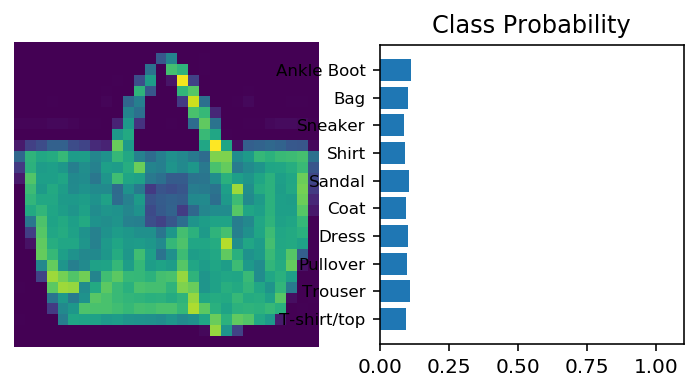

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter=iter(testloader)
images, labels = dataiter.next()
img=images[21]

ps=torch.exp(model(img)) #To calculate the class probabilities i.e. softmax for img

view_classify(img, ps, version='Fashion') #to plot test image and its classification graph

In [14]:
model=Classifier()
images, labels = next(iter(testloader))
ps=torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


In [15]:
top_p, top_class = ps.topk(1, dim=1)
#Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])


In [16]:
equals = top_class == labels.view(*top_class.shape)

In [18]:
print(equals)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.uint8)


In [17]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


In [19]:
#TESTING AFTER TRAINING...i.e. VALIDATION PASS

In [31]:
model=Classifier()
criterion = nn.NLLLoss()
optimizer=optim.Adam(model.parameters(), lr=0.003)

epochs=30
steps=0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss=0
    for images, labels in trainloader:        
        optimizer.zero_grad()
        
        logps=model(images) #shortcut to write forward pass 
        loss=criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss=0
        accuracy=0
        
        #Turn of gradients as they are not required in validation step
        with torch.no_grad():
            model.eval() #comment for demo without dropout
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps=torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                
        model.train()#comment for demo without dropout
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss : {:.3f}..".format(running_loss/len(trainloader)),
              "Test loss : {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy : {:.3f}..".format(accuracy/len(testloader)))
        
                

Epoch: 1/30.. Training loss : 0.518.. Test loss : 0.469.. Test Accuracy : 0.006..
Epoch: 2/30.. Training loss : 0.390.. Test loss : 0.421.. Test Accuracy : 0.006..
Epoch: 3/30.. Training loss : 0.358.. Test loss : 0.378.. Test Accuracy : 0.005..
Epoch: 4/30.. Training loss : 0.334.. Test loss : 0.374.. Test Accuracy : 0.005..
Epoch: 5/30.. Training loss : 0.315.. Test loss : 0.383.. Test Accuracy : 0.006..
Epoch: 6/30.. Training loss : 0.302.. Test loss : 0.374.. Test Accuracy : 0.006..
Epoch: 7/30.. Training loss : 0.290.. Test loss : 0.373.. Test Accuracy : 0.005..
Epoch: 8/30.. Training loss : 0.280.. Test loss : 0.394.. Test Accuracy : 0.006..
Epoch: 9/30.. Training loss : 0.273.. Test loss : 0.368.. Test Accuracy : 0.004..
Epoch: 10/30.. Training loss : 0.266.. Test loss : 0.361.. Test Accuracy : 0.005..
Epoch: 11/30.. Training loss : 0.258.. Test loss : 0.359.. Test Accuracy : 0.006..
Epoch: 12/30.. Training loss : 0.252.. Test loss : 0.357.. Test Accuracy : 0.006..
Epoch: 13/30.

In [32]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

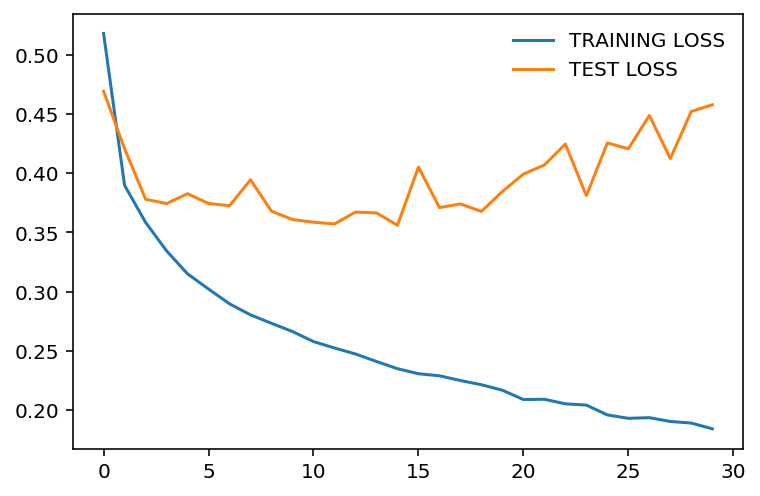

In [36]:
plt.plot(train_losses, label = 'TRAINING LOSS')
plt.plot(test_losses, label = 'TEST LOSS')
plt.legend(frameon=False)

In [26]:
#THE ABV O/P SHOWS OVERFITTING WHERE OUR MODEL GETS BETTER ON TRAINING DATA BUT GETS WORSE ON VALIDATION/TEST DATA. THIS IS BCZ 
#WHEN IT TRAINS THE MODEL,IT FAILS TO GENERALIZE THE DATA OUTSIDE OF THE TRAINING SET.

In [27]:
#SOLUTION IS REGULARIZATION...SPECIFICALLY DROPOUT (code is added to above classes...comment wherever necessary for demo without
#dropout)

In [28]:
#WE WANT DROPOUT ONLY FOR TRAINING(to prevent overfitting) CUZ WE WANT THE ENTIRE NETWORK TO BE USED FOR INFERENCE/
#VALIDATION/TESTING. 

In [29]:
#model.eval() will turn off dropout...model.train() will turn on dropout

In [ ]:
#BELOW CODE IS FOR SAVING A MODEL AND THEN LOADING IT IN FUTURE

In [37]:
print(model) #to print the model(demo)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [38]:
print(model.state_dict().keys()) #to print keys of dict containing state of the model(demo)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [45]:
#TO SAVE THE MODEL
"""torch.save(model.state_dict(), 'checkpoint.pth')""" #checkpoint.pth is a file. pth is extension for pytorch checkpoint files
#for the abv model, we need to load a model with same size as the saved model..or else it will result in error if we gv
#different sizec..lyk instead of 256 if we 512, then it becomes error.tht is why we need to save a few more details

In [49]:
checkpoint = {'input_size' : 784,
             'output_size' : 10,
             #'hidden_layers' : [each.out_features for each in model.hidden_layers], #DOnt know y it doesnt work..
             'state_dict' : model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [50]:
#TO LOAD THE MODEL
"""state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())""" #This is for torch.save(___,'')
#TO LOAD STATE_DICT TO NETWORK
#model.load_state_dict(state_dict)

"state_dict = torch.load('checkpoint.pth')\nprint(state_dict.keys())"

In [56]:
def load_checkpoint(filepath): #will not work until hidden_layers is rectified
    checkpoint = torch.load(filepath)
    model=Classifier(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers']                    )
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [57]:
model=load_checkpoint('checkpoint.pth')
print(model)

TypeError: __init__() takes 1 positional argument but 3 were given